In [5]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
# Load dataset
df = pd.read_csv('C:/Users/ADMIN/Desktop/Projects/ANN_Project/sonar_data.csv', header=None)
X = df.drop(columns=60)
y = df[60].map({'R': 0, 'M': 1})

In [8]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=seed)

In [10]:
# Define model builder for tuning
def model_builder(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units1', 32, 128, step=32), activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_1', [0.01, 0.001]))))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Keras Tuner
tuner = kt.RandomSearch(model_builder, objective='val_accuracy', max_trials=5, overwrite=True,
                        directory='tuner_logs', project_name='sonar_model')

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

# Stratified 5-fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
val_scores = []

C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\nTraining fold {fold}...")
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx].values, y_train.iloc[val_idx].values

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'fold{fold}_model.keras', save_best_only=True)

    model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping, checkpoint], verbose=0)

    val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    val_scores.append(val_acc)
    print(f"Fold {fold} accuracy: {val_acc:.4f}")

print(f"\nAverage CV Accuracy: {np.mean(val_scores):.4f}")


Training fold 1...
Fold 1 accuracy: 0.7647

Training fold 2...
Fold 2 accuracy: 0.8182

Training fold 3...
Fold 3 accuracy: 0.7273

Training fold 4...
Fold 4 accuracy: 0.8788

Training fold 5...
Fold 5 accuracy: 0.9091

Average CV Accuracy: 0.8196


In [13]:
# Final training on full training set
final_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_model.fit(X_train, y_train, epochs=100, batch_size=32,
                validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [14]:
# Test evaluation
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9048


In [16]:
# Save final model
final_model.save('C:/Users/ADMIN/Desktop/Projects/ANN_Project/final_sonar_model.keras')

In [17]:
# Confusion Matrix and Classification Report
y_pred = (final_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.91      0.91      0.91        22

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42

Confusion Matrix:
 [[18  2]
 [ 2 20]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ROC-AUC Score: 0.9682
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


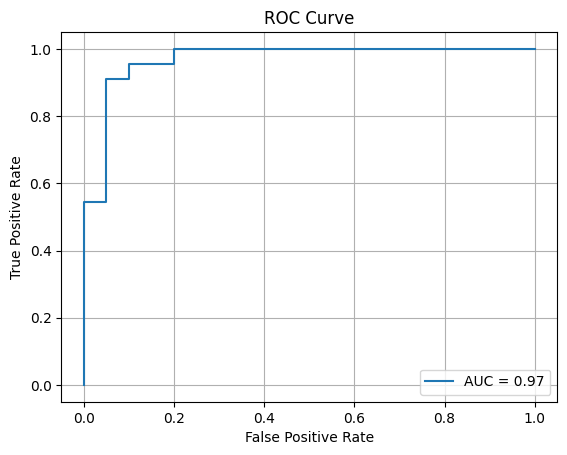

In [18]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, final_model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(y_test, final_model.predict(X_test))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.grid(); plt.show()

PermutationExplainer explainer: 43it [00:23,  1.76it/s]                        


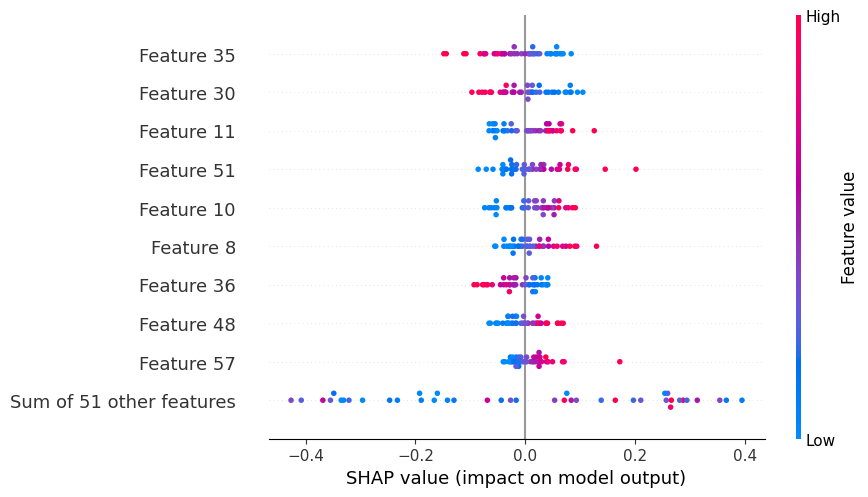

In [19]:
# SHAP explainability
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)